# Logistic regression and COVID-19 in France and other countries (Italy, Spain, UK,....)

In [1]:
# import libraries 
import itertools
from datetime import timedelta

import numpy as np
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import pandas as pd
from sklearn.linear_model import LinearRegression

FS = (16, 9)  # figure size

## Import of dataset

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
df = pd.read_csv(url)
df.head(-10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,2336,2339,2343,2346,2354,2363,2370,2373,2378,2385
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1270,1277,1281,1287,1291,1296,1303,1310,1315,1324
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2831,2836,2840,2843,2849,2853,2856,2861,2863,2866
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,91,91,91,92,92,93,93,96,96,97
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,431,436,439,442,444,448,452,457,459,461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Falkland Islands (Malvinas),United Kingdom,-51.796300,-59.523600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,Gibraltar,United Kingdom,36.140800,-5.353600,0,0,0,0,0,0,...,34,43,45,47,53,59,59,62,63,65
260,Isle of Man,United Kingdom,54.236100,-4.548100,0,0,0,0,0,0,...,25,25,25,25,25,25,25,25,25,25
261,Montserrat,United Kingdom,16.742498,-62.187366,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


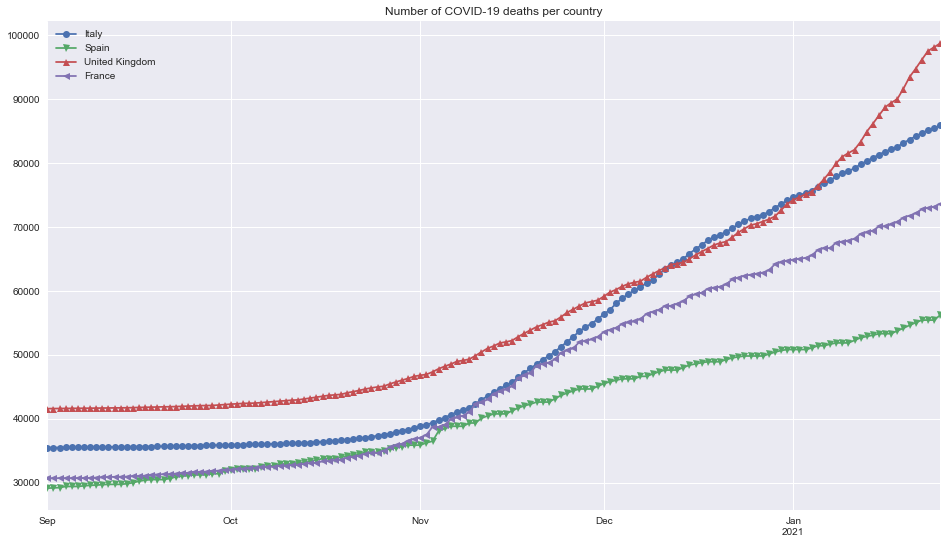

In [3]:
total = df.drop(['Province/State', 'Lat', 'Long'],
                axis=1).groupby('Country/Region').sum().max(axis=1).sort_values(ascending=False)
countries = total.index.to_list()
deaths = pd.DataFrame()

for country in countries:
    temp = df[df['Country/Region'] == country][df.columns[4:]].T.sum(axis=1)
    temp.index = pd.to_datetime(temp.index)
    temp = temp.to_frame(country)
    deaths = pd.concat([deaths, temp], axis=1)
    
start = '2020-09'
ax = deaths[['Italy', 'Spain', 'United Kingdom', 'France']][start:].plot(style='-', 
                                                                         figsize=FS)
markers = itertools.cycle(("o", "v", "^", "<", ">", "s", "p",
                           "P", "*", "h", "X", "D", '.')) # style 

for i, line in enumerate(ax.get_lines()):
    marker = next(markers)
    line.set_marker(marker)
    
_ = ax.legend()
_ = ax.set_title("Number of COVID-19 deaths per country")

## Functions to make logistic curve

In [4]:
def plot_ratios(country, death_min=0, death_max=None):
    """ Plot the proportional growth rate with respect to D, 
        on the interval (death_min, death_max).
    """
    country = country[country > death_min]
    
    if death_max is not None:
        country = country[country < death_max]
        
    slopes = 0.5 * (country.diff(1) - country.diff(-1))
    ratios = slopes / country
    x = country.values[1:-1]
    y = ratios.values[1:-1]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(x, y, 'o')
    _ = ax.set_xlabel('D(t)')
    _ = ax.set_ylabel('Ratios of slopes to function values')
    
    return x, y

In [5]:
def linear_regression(x, y):
    """ Find the coefficients of the linear function y = ax + b,  
        using a linear regression.
    """
    X = x.reshape(-1, 1) 
    reg = LinearRegression(fit_intercept=True, normalize=True)
    _ = reg.fit(X, y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_hat = a * x + b
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(x, y, 'o')
    _ = plt.plot(x, y_hat, '-', label='Linear regression')
    _ = ax.set_xlabel('D(t)')
    _ = ax.set_ylabel('Ratios of slopes to function values')
    _ = ax.legend()
    
    return a, b

In [6]:
def plot_t0(a, b, country, death_min=0, death_max=None, t0=0):
    """ Find a value of t0 such that the logistic curve is as close 
        as possible to the data on the given interval.
    """
    k = b
    L = -b / a
    country = country[country > death_min]
    
    if death_max is not None:
        country = country[country < death_max]
        
    logis = L / (1. + np.exp(-k * (np.arange(len(country)) - t0)))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(logis, 'o')
    _ = plt.plot(country.values, 'd')
    
    return L, k

In [7]:
def logistic_regression(country, death_min, L, k, t0, days_before=30, days_after=30,
                  figsize=FS):
    """ Plot the logistic curve on an extended interval, 
        against the real data.
    """
    country_original = country.copy(deep=True)
    country = country[country > death_min]
    country = country.to_frame('Deaths')
    country_start = country.index.min()
    country_end = country.index.max()
    start = country_start - timedelta(days=days_before)
    end = country_end + timedelta(days=days_after)
    ix = pd.date_range(start=start, end=end, freq='D')
    country = country.reindex(ix)
    country['idx'] = np.arange(len(country))
    country['idx'] -= country.loc[country_start, 'idx']
    country['prediction'] = L / (1. + np.exp(-k * (country['idx'].values - t0)))
    ax = country['prediction'].plot(figsize=figsize, logy=False)
    _ = country_original[start:].plot(ax=ax, style='v')
    _ = ax.legend()
    plt.xlabel("Month")
    plt.ylabel("Deaths")

## France

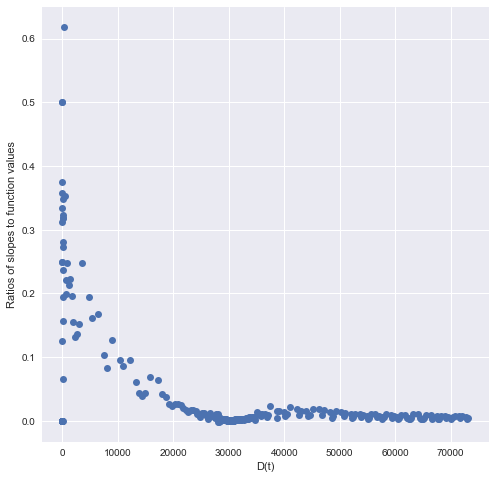

In [8]:
country_name = 'France'
country = deaths[country_name]
x, y = plot_ratios(country)

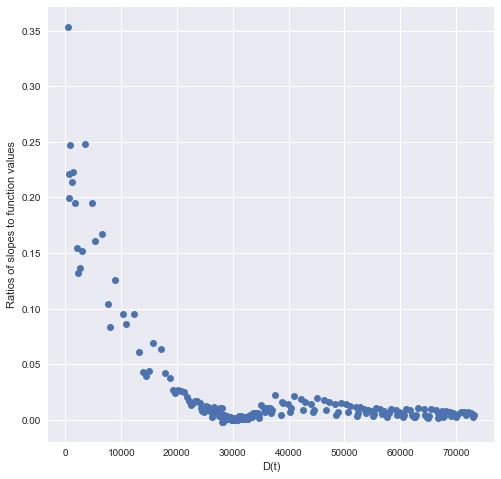

In [9]:
death_min = 200
x, y = plot_ratios(country, death_min)

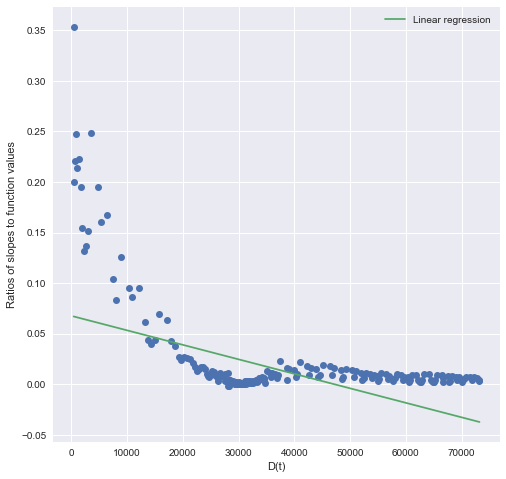

In [10]:
a, b = linear_regression(x, y)

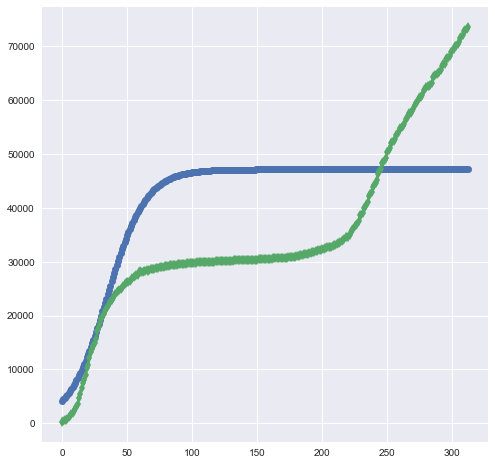

In [11]:
t0 = 34.5
L, k = plot_t0(a, b, country, death_min, t0=t0)

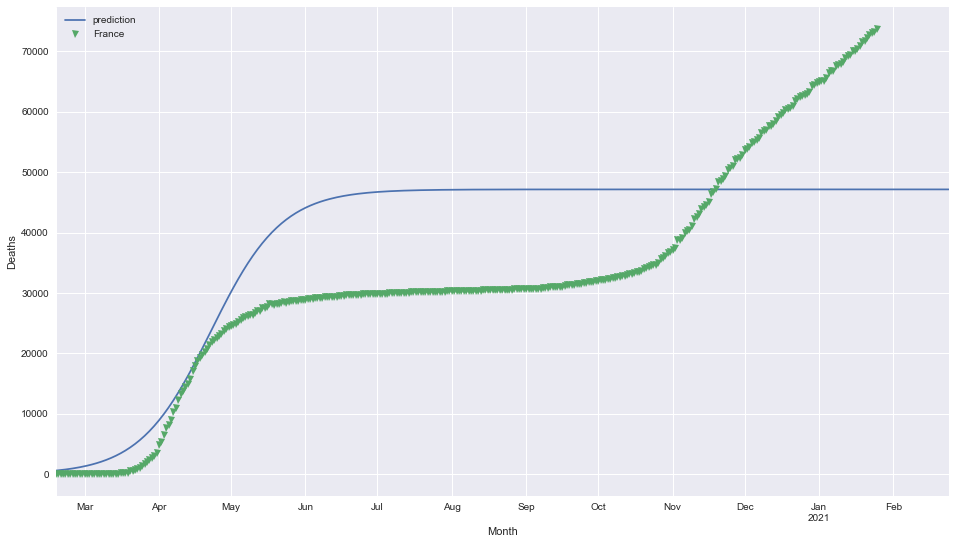

In [12]:
logistic_regression(country, death_min, L, k, t0, figsize=FS)

## Spain

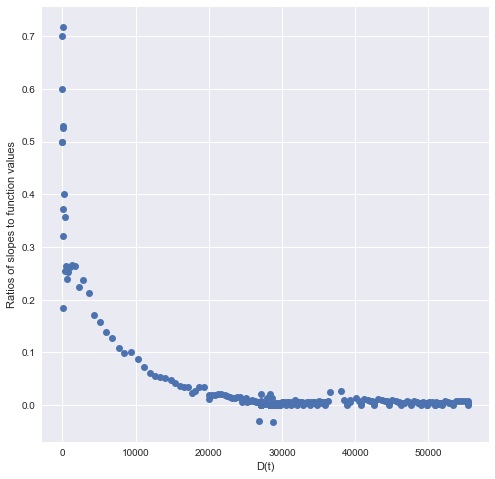

In [13]:
country_name = 'Spain'
country = deaths[country_name]
x, y = plot_ratios(country)

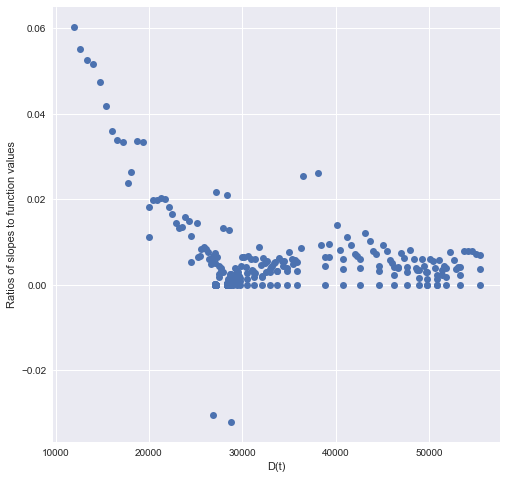

In [14]:
death_min = 11000
x, y = plot_ratios(country, death_min)

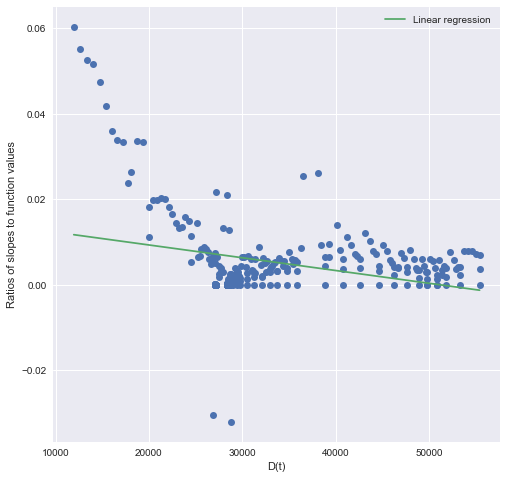

In [15]:
a, b = linear_regression(x, y)

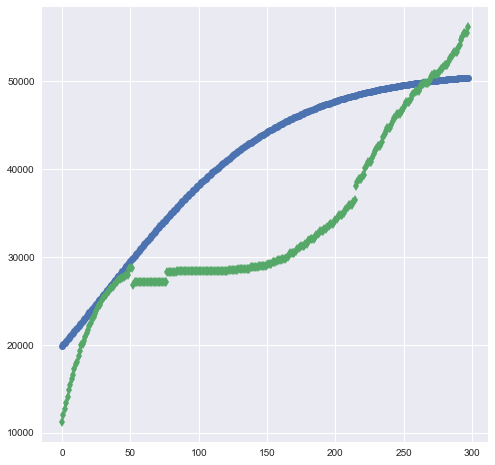

In [16]:
t0 = 30
L, k = plot_t0(a, b, country, death_min, t0=t0)

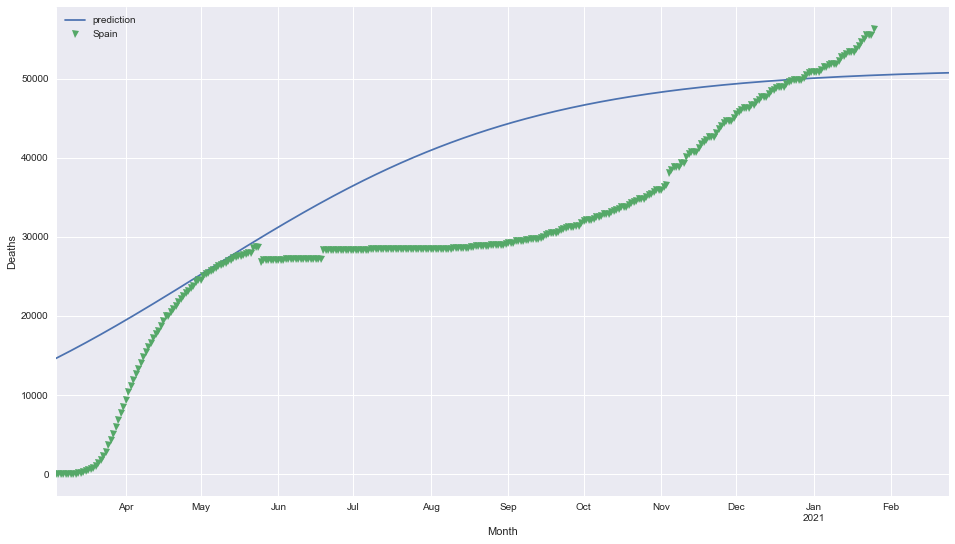

In [17]:
logistic_regression(country, death_min, L, k, t0, figsize=FS)

## Italy

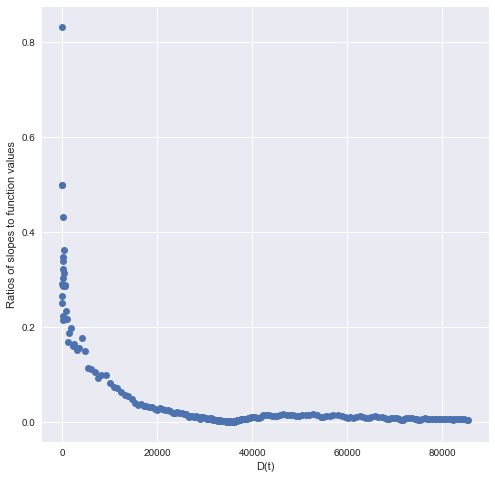

In [18]:
country_name = 'Italy'
country = deaths[country_name]
x, y = plot_ratios(country)

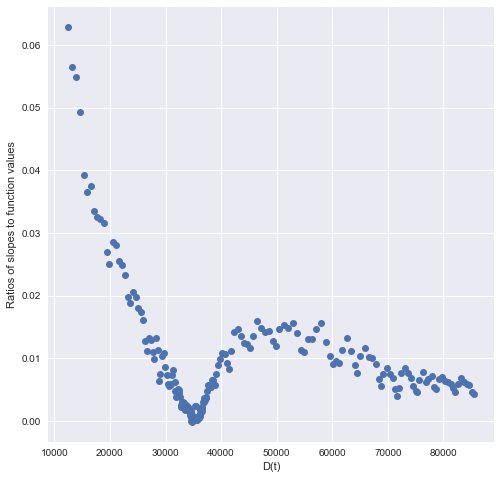

In [19]:
death_min = 11000
x, y = plot_ratios(country, death_min)

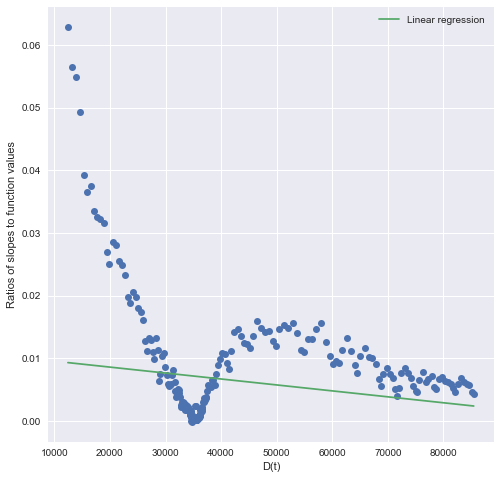

In [20]:
a, b = linear_regression(x, y)

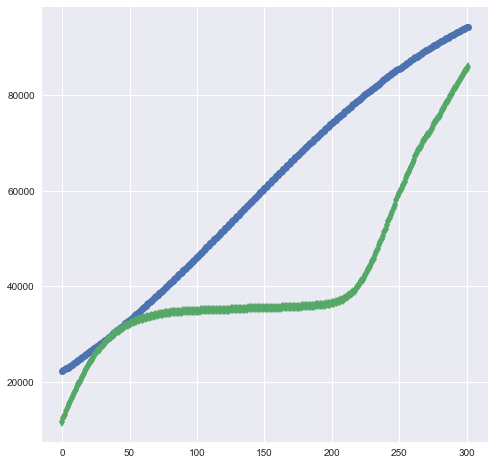

In [24]:
t0 = 131.5
L, k = plot_t0(a, b, country, death_min, t0=t0)

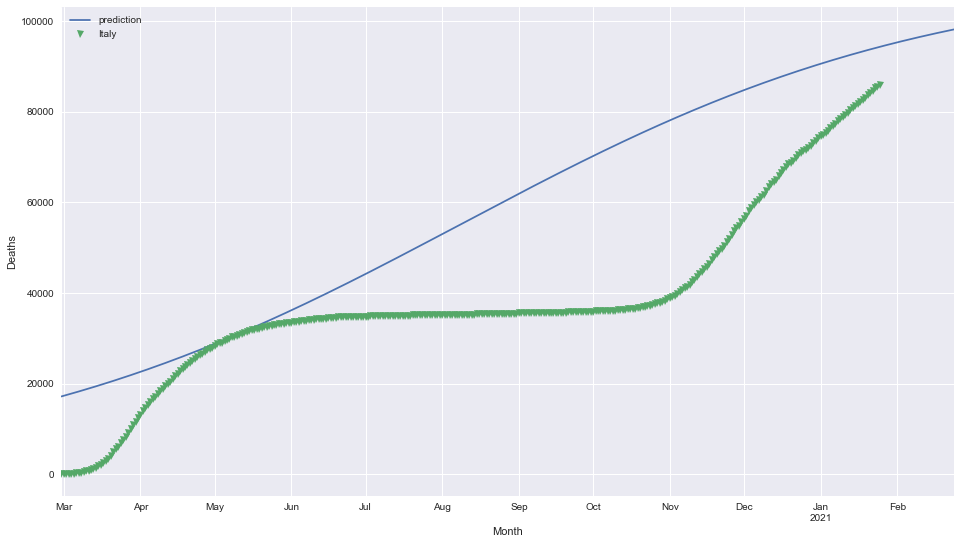

In [25]:
logistic_regression(country, death_min, L, k, t0, figsize=FS)